# model_evaluation

> The model evaluation module provides a set of functions for model evaluation

In [ ]:
#| default_exp model_evaluation

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aatools.datasets import load_predictions

In [ ]:
#| export

def metrics_by_threshold(y_true, # Ground truth (correct) target values
                         y_proba, # Estimated probability as returned by a binary classifier
                         n_points:int=100): # Number of points on which to evaluate
    """Returns dataframe with several binary classification metrics as a function of the decision threshold"""
    
    # Calculate tn, fp, fn, tp for different thresholds
    cm_thr = []
    for thr in np.linspace(0,1,100):
        y_pred = np.where(y_proba >= thr, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cm_thr.append([thr, tn, fp, fn, tp])
   
    cm_thr_df = pd.DataFrame(cm_thr, columns=['thr', 'tn', 'fp', 'fn', 'tp'])
   
    ## Calculation of metrics

    cm_thr_df['precision'] = cm_thr_df['tp'] / (cm_thr_df['tp'] + cm_thr_df['fp'])
    cm_thr_df['recall'] = cm_thr_df['tp'] / (cm_thr_df['tp'] + cm_thr_df['fn'])
    cm_thr_df['accuracy'] = (cm_thr_df['tp'] + cm_thr_df['tn']) / (cm_thr_df['tp'] + cm_thr_df['fn'] + cm_thr_df['fp'] + cm_thr_df['tn'])
    cm_thr_df['f1'] = (2*cm_thr_df['tp']) / (2*cm_thr_df['tp'] + cm_thr_df['fn'] + cm_thr_df['fp'])
    cm_thr_df['specificity'] = cm_thr_df['tn'] / (cm_thr_df['tn'] + cm_thr_df['fp'])
    
    # Matthews correlation coefficient
    num_mcc = (cm_thr_df['tp'] * cm_thr_df['tn']) - (cm_thr_df['fp'] * cm_thr_df['fn'])
    subrad_mcc = ((cm_thr_df['tp'] + cm_thr_df['fp']) * 
                  (cm_thr_df['tp'] + cm_thr_df['fn']) *
                  (cm_thr_df['tn'] + cm_thr_df['fp']) *
                  (cm_thr_df['tn'] + cm_thr_df['fn']))
    cm_thr_df['mcc'] = num_mcc / np.sqrt(subrad_mcc)
   
    return cm_thr_df

To test we load the predictions dataset

In [ ]:
preds = load_predictions()

and calculate the metrics for 100 different thresholds

In [ ]:
mthr = metrics_by_threshold(preds['y_true'], preds['y_proba'])

we plot the results

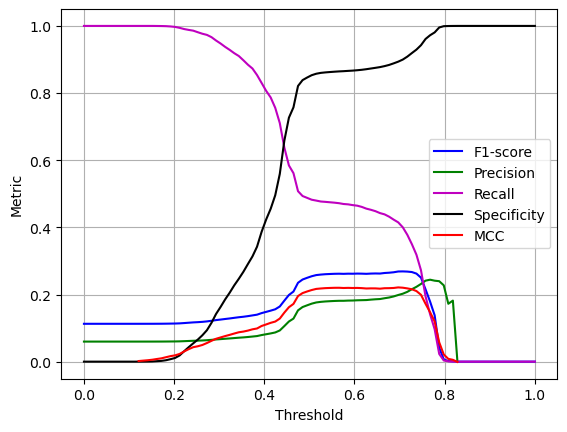

In [ ]:
fig, ax = plt.subplots()
ax.plot(mthr['thr'], mthr['f1'], color='b', label=f'F1-score')
ax.plot(mthr['thr'], mthr['precision'], color='g', label=f'Precision')
ax.plot(mthr['thr'], mthr['recall'], color='m', label=f'Recall')
ax.plot(mthr['thr'], mthr['specificity'], color='k', label=f'Specificity')
ax.plot(mthr['thr'], mthr['mcc'], color='r', label=f'MCC')
ax.legend()
ax.grid()
ax.set_xlabel('Threshold')
ax.set_ylabel('Metric')
plt.show()

## K-S Statistic

> The Kolmogorov–Smirnov test (K-S test or KS test) is a nonparametric test of the equality of continuous (or discontinuous), one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test). In essence, the test answers the question *What is the probability that this collection of samples could have been drawn from that probability distribution?* or, in the second case, *What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?*.
>
> --- [Kolgomorov-Smirnov Test](https://en.wikipedia.org/w/index.php?title=Kolmogorov%E2%80%93Smirnov_test&oldid=1112534660)

>Note that the two-sample test checks whether the two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal). Again, tables of critical values have been published. A shortcoming of the univariate Kolmogorov–Smirnov test is that it is not very powerful because it is devised to be sensitive against all possible types of differences between two distribution functions.
>
> --- [Kolgomorov-Smirnov Test](https://en.wikipedia.org/w/index.php?title=Kolmogorov%E2%80%93Smirnov_test&oldid=1112534660)

The function `bin_class_ks` uses scipy [ks_2samp()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) to test whether the distributions of the positive and negative classes from a binary classifier are from the same distribution

In [ ]:
#| export

def bin_class_ks(y_true, # Ground truth (correct) target values {0,1}
                y_proba): # Estimated probability as returned by a binary classifier
    
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
   
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
   
    ks = ks_2samp(class0['proba'], class1['proba'])
    
    return ks.statistic, ks.pvalue

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()